# Corporación Favorita Grocery Sales Forecasting
**w03_d01_MODEL_baseline.ipynb**

**Author:** Alberto Diaz Durana  
**Date:** November 2025  
**Purpose:** Establish XGBoost baseline model with comprehensive evaluation

---

## Objectives

This notebook accomplishes the following:

- Load final feature-engineered dataset from Week 2 (w02_d05_FE_final.pkl)
- Create chronological train/test split (Jan-Feb train, March 2014 test)
- Train XGBoost baseline model with default parameters
- Evaluate with 6 comprehensive metrics (MAE, RMSE, Bias, MAD, rMAD, MAPE)
- Visualize predictions and residuals
- Document baseline performance for Week 3 comparison

---

## Business Context

**Why baseline modeling matters:**

- Establishes performance benchmark for hyperparameter tuning
- Validates feature engineering efforts from Week 2
- Identifies model strengths and weaknesses before optimization
- Provides interpretable metrics for stakeholder communication

**Expected outcomes:**
- RMSE baseline documented
- Feature importance from default XGBoost
- Clear under/over-forecasting patterns identified

---

In [1]:
# Cell 1: Imports and Project Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

# XGBoost and evaluation
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Visualization settings
plt.style.use('default')
sns.set_palette("husl")

# Reproducibility
np.random.seed(42)

print("Library versions:")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"xgboost: {xgb.__version__}")
print(f"matplotlib: {plt.matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")

Library versions:
pandas: 2.1.4
numpy: 1.26.4
xgboost: 2.0.3
matplotlib: 3.10.7
seaborn: 0.13.2


## 1. Data Loading & Verification

**Objective:** Load final feature-engineered dataset from Week 2 Day 5

**Activities:**
- Load w02_d05_FE_final.pkl (300,896 rows × 57 columns expected)
- Verify dataset structure and shape
- Check feature count (29 engineered + 28 base = 57 total)
- Confirm temporal range (2013-01-02 to 2017-08-15)
- Verify no data quality issues before modeling

**Expected output:** 
- Dataset loaded successfully
- Shape: (300896, 57)
- Date range confirmed
- No missing values in critical features

In [2]:
# Determine paths (works from notebooks/ or project root)
current_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
PROJECT_ROOT = current_dir.parent if current_dir.name == 'notebooks' else current_dir

DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
DATA_RESULTS = PROJECT_ROOT / 'data' / 'results' / 'features'
OUTPUTS_FIGURES = PROJECT_ROOT / 'outputs' / 'figures' / 'features'

print(f"\nProject root: {PROJECT_ROOT.resolve()}")
print(f"Data processed: {DATA_PROCESSED.resolve()}")
print(f"Results output: {DATA_RESULTS.resolve()}")
print(f"Figures output: {OUTPUTS_FIGURES.resolve()}")


Project root: D:\Demand-forecasting-in-retail
Data processed: D:\Demand-forecasting-in-retail\data\processed
Results output: D:\Demand-forecasting-in-retail\data\results\features
Figures output: D:\Demand-forecasting-in-retail\outputs\figures\features


In [3]:
# Cell 2: Load Final Feature-Engineered Dataset

# Load the final dataset from Week 2 Day 5
file_path = DATA_PROCESSED / 'w02_d05_FE_final.pkl'  
df = pd.read_pickle(file_path)

print("Dataset loaded successfully")
print(f"Shape: {df.shape}")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"\nColumn count: {len(df.columns)}")
print(f"\nFirst few columns:")
print(df.columns.tolist()[:10])
print(f"\nLast few columns:")
print(df.columns.tolist()[-10:])
print(f"\nData types summary:")
print(df.dtypes.value_counts())
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Dataset loaded successfully
Shape: (300896, 57)

Date range: 2013-01-02 00:00:00 to 2017-08-15 00:00:00

Column count: 57

First few columns:
['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'family', 'class', 'perishable', 'city']

Last few columns:
['cluster_avg_sales', 'cluster_median_sales', 'cluster_std_sales', 'item_avg_sales', 'item_median_sales', 'item_std_sales', 'item_count', 'item_total_sales', 'promo_item_avg_interaction', 'promo_cluster_interaction']

Data types summary:
float64           30
int64              9
int32              9
object             8
datetime64[ns]     1
Name: count, dtype: int64

Memory usage: 219.9 MB


### 1.1 Data Quality Verification

**Objective:** Verify dataset quality before modeling

**Checks:**
- Temporal order preserved (critical for time series)
- Missing values assessment
- Feature types validation
- Basic statistics

In [4]:
# Cell 3: Data Quality Verification

print("=== DATA QUALITY CHECK ===\n")

# Check temporal order
print("1. Temporal Order:")
is_sorted = df.sort_values(['store_nbr', 'item_nbr', 'date']).equals(df)
print(f"   Dataset sorted by (store_nbr, item_nbr, date): {is_sorted}")

# Missing values
print(f"\n2. Missing Values:")
missing = df.isnull().sum()
missing_features = missing[missing > 0].sort_values(ascending=False)
if len(missing_features) > 0:
    print(f"   Features with missing values:")
    for col, count in missing_features.head(10).items():
        pct = (count / len(df)) * 100
        print(f"   - {col}: {count:,} ({pct:.2f}%)")
else:
    print("   No missing values found")

# Target variable statistics
print(f"\n3. Target Variable (unit_sales):")
print(f"   Mean: {df['unit_sales'].mean():.2f}")
print(f"   Median: {df['unit_sales'].median():.2f}")
print(f"   Std: {df['unit_sales'].std():.2f}")
print(f"   Min: {df['unit_sales'].min():.2f}")
print(f"   Max: {df['unit_sales'].max():.2f}")
print(f"   Zeros: {(df['unit_sales'] == 0).sum():,} ({(df['unit_sales'] == 0).sum() / len(df) * 100:.1f}%)")

# Feature categories
print(f"\n4. Feature Categories:")
print(f"   Total features: {len(df.columns)}")
lag_features = [col for col in df.columns if 'lag' in col.lower()]
rolling_features = [col for col in df.columns if ('avg' in col or 'std' in col) and 'sales' in col]
oil_features = [col for col in df.columns if 'oil' in col.lower()]
agg_features = [col for col in df.columns if any(x in col for x in ['store_avg', 'cluster_avg', 'item_avg'])]
promo_features = [col for col in df.columns if 'promo' in col.lower()]

print(f"   - Lag features: {len(lag_features)}")
print(f"   - Rolling features: {len(rolling_features)}")
print(f"   - Oil features: {len(oil_features)}")
print(f"   - Aggregation features: {len(agg_features)}")
print(f"   - Promotion features: {len(promo_features)}")

print(f"\n5. Date Range for Modeling:")
print(f"   Full range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"   Total days: {(df['date'].max() - df['date'].min()).days}")

=== DATA QUALITY CHECK ===

1. Temporal Order:
   Dataset sorted by (store_nbr, item_nbr, date): True

2. Missing Values:
   Features with missing values:
   - unit_sales_lag30: 291,884 (97.00%)
   - holiday_type: 273,698 (90.96%)
   - holiday_name: 273,698 (90.96%)
   - unit_sales_lag14: 204,230 (67.87%)
   - unit_sales_lag7: 119,961 (39.87%)
   - unit_sales_lag1: 19,692 (6.54%)
   - unit_sales_7d_std: 19,692 (6.54%)
   - unit_sales_14d_std: 19,692 (6.54%)
   - unit_sales_30d_std: 19,692 (6.54%)
   - oil_price_lag30: 30 (0.01%)

3. Target Variable (unit_sales):
   Mean: 6.79
   Median: 3.00
   Std: 15.63
   Min: -92.00
   Max: 2534.00
   Zeros: 0 (0.0%)

4. Feature Categories:
   Total features: 57
   - Lag features: 7
   - Rolling features: 12
   - Oil features: 6
   - Aggregation features: 4
   - Promotion features: 4

5. Date Range for Modeling:
   Full range: 2013-01-02 to 2017-08-15
   Total days: 1686


Key observations:

Temporal order preserved 
High NaN in lag features expected (sparse retail data) 
No zeros in dataset (sparse format - only recorded sales) 
Feature categories align with Week 2 engineering 

## 2. Train/Test Split (Chronological)

**Objective:** Create time-based train/test split for realistic forecasting evaluation

**Strategy:**
- **Training period:** January-February 2014 (2 months)
- **Test period:** March 2014 (1 month)
- **No shuffling:** Preserve temporal order (critical for time series)
- **Rationale:** Simulate realistic forecast scenario (predict next month using past 2 months)

**Expected split:**
- Train: ~60-70% of 2014 Q1 data
- Test: ~30-40% of 2014 Q1 data
- Course requirement: Model Jan-Mar 2014 only (Guayas, top-3 families)

In [5]:
# Cell 4: Chronological Train/Test Split

print("=== TRAIN/TEST SPLIT (CHRONOLOGICAL) ===\n")

# Filter to Jan-Mar 2014 only (course requirement)
print("1. Filter to Q1 2014 (Jan-Mar):")
df_2014q1 = df[(df['date'] >= '2014-01-01') & (df['date'] <= '2014-03-31')].copy()
print(f"   Original dataset: {len(df):,} rows")
print(f"   Q1 2014 subset: {len(df_2014q1):,} rows ({len(df_2014q1)/len(df)*100:.1f}%)")
print(f"   Date range: {df_2014q1['date'].min().date()} to {df_2014q1['date'].max().date()}")

# Split: Jan-Feb (train), March (test)
print(f"\n2. Chronological Split:")
train = df_2014q1[df_2014q1['date'] < '2014-03-01'].copy()
test = df_2014q1[df_2014q1['date'] >= '2014-03-01'].copy()

print(f"   Train (Jan-Feb 2014): {len(train):,} rows")
print(f"     Date range: {train['date'].min().date()} to {train['date'].max().date()}")
print(f"     Days: {(train['date'].max() - train['date'].min()).days + 1}")

print(f"   Test (March 2014): {len(test):,} rows")
print(f"     Date range: {test['date'].min().date()} to {test['date'].max().date()}")
print(f"     Days: {(test['date'].max() - test['date'].min()).days + 1}")

print(f"\n3. Split Ratio:")
print(f"   Train: {len(train)/len(df_2014q1)*100:.1f}%")
print(f"   Test: {len(test)/len(df_2014q1)*100:.1f}%")

# Verify no data leakage (test dates > train dates)
print(f"\n4. Data Leakage Check:")
latest_train_date = train['date'].max()
earliest_test_date = test['date'].min()
print(f"   Latest train date: {latest_train_date.date()}")
print(f"   Earliest test date: {earliest_test_date.date()}")
print(f"   No overlap: {latest_train_date < earliest_test_date}")

# Target variable distribution
print(f"\n5. Target Distribution:")
print(f"   Train unit_sales - Mean: {train['unit_sales'].mean():.2f}, Median: {train['unit_sales'].median():.2f}")
print(f"   Test unit_sales - Mean: {test['unit_sales'].mean():.2f}, Median: {test['unit_sales'].median():.2f}")

=== TRAIN/TEST SPLIT (CHRONOLOGICAL) ===

1. Filter to Q1 2014 (Jan-Mar):
   Original dataset: 300,896 rows
   Q1 2014 subset: 12,668 rows (4.2%)
   Date range: 2014-01-01 to 2014-03-31

2. Chronological Split:
   Train (Jan-Feb 2014): 7,982 rows
     Date range: 2014-01-01 to 2014-02-28
     Days: 59
   Test (March 2014): 4,686 rows
     Date range: 2014-03-01 to 2014-03-31
     Days: 31

3. Split Ratio:
   Train: 63.0%
   Test: 37.0%

4. Data Leakage Check:
   Latest train date: 2014-02-28
   Earliest test date: 2014-03-01
   No overlap: True

5. Target Distribution:
   Train unit_sales - Mean: 7.21, Median: 3.00
   Test unit_sales - Mean: 7.26, Median: 3.00


Gap Period to Prevent Lag Feature Leakage
The Issue:

Our max lag is 30 days (unit_sales_lag30)
If we predict March 1 without a gap:

lag1 uses Feb 28 (training data)
lag7 uses Feb 22 (training data)
lag30 uses Jan 30 (training data)


This creates subtle information leakage from training into test predictions

Standard Solution:
Leave a gap period equal to maximum lag (30 days) between train and test.

## 2. Train/Test Split (Chronological with Gap Period)

**Objective:** Create time-based train/test split with gap period to prevent lag feature leakage

**Strategy:**
- **Training period:** January 1 - February 21, 2014 (52 days)
- **Gap period:** February 22 - February 28, 2014 (7 days) - EXCLUDED from both sets
- **Test period:** March 1 - March 31, 2014 (31 days)
- **No shuffling:** Preserve temporal order (critical for time series)

**Rationale for 7-day gap:**
- Prevents leakage for lag7 feature (strongest autocorrelation: r=0.40)
- Balances training data availability (52 days) vs leak prevention
- lag1 predictions use gap period data (acceptable trade-off)
- lag14 and lag30 still use some training period (documented limitation)

**Trade-offs documented:**
- Strict 30-day gap would leave only 30 days training (insufficient)
- 7-day gap pragmatically prevents most critical leakage
- Acceptable for academic project scope

In [6]:
# Cell 4: Chronological Train/Test Split with Gap Period

print("=== TRAIN/TEST SPLIT WITH GAP PERIOD ===\n")

# Filter to Jan-Mar 2014 only (course requirement)
print("1. Filter to Q1 2014 (Jan-Mar):")
df_2014q1 = df[(df['date'] >= '2014-01-01') & (df['date'] <= '2014-03-31')].copy()
print(f"   Original dataset: {len(df):,} rows")
print(f"   Q1 2014 subset: {len(df_2014q1):,} rows ({len(df_2014q1)/len(df)*100:.1f}%)")
print(f"   Date range: {df_2014q1['date'].min().date()} to {df_2014q1['date'].max().date()}")

# Split with 7-day gap: Train (Jan 1 - Feb 21), Gap (Feb 22-28), Test (Mar 1-31)
print(f"\n2. Chronological Split with Gap:")
train = df_2014q1[df_2014q1['date'] <= '2014-02-21'].copy()
gap = df_2014q1[(df_2014q1['date'] > '2014-02-21') & (df_2014q1['date'] < '2014-03-01')].copy()
test = df_2014q1[df_2014q1['date'] >= '2014-03-01'].copy()

print(f"   Train (Jan 1 - Feb 21, 2014): {len(train):,} rows")
print(f"     Date range: {train['date'].min().date()} to {train['date'].max().date()}")
print(f"     Days: {(train['date'].max() - train['date'].min()).days + 1}")

print(f"   Gap (Feb 22 - Feb 28, 2014): {len(gap):,} rows [EXCLUDED]")
print(f"     Date range: {gap['date'].min().date()} to {gap['date'].max().date()}")
print(f"     Days: {(gap['date'].max() - gap['date'].min()).days + 1}")
print(f"     Purpose: Prevent lag7 feature leakage")

print(f"   Test (March 1 - 31, 2014): {len(test):,} rows")
print(f"     Date range: {test['date'].min().date()} to {test['date'].max().date()}")
print(f"     Days: {(test['date'].max() - test['date'].min()).days + 1}")

print(f"\n3. Split Ratio (excluding gap):")
print(f"   Train: {len(train)/(len(train)+len(test))*100:.1f}%")
print(f"   Test: {len(test)/(len(train)+len(test))*100:.1f}%")
print(f"   Gap excluded: {len(gap):,} rows ({len(gap)/len(df_2014q1)*100:.1f}% of Q1)")

# Verify gap period
print(f"\n4. Gap Period Verification:")
latest_train_date = train['date'].max()
earliest_test_date = test['date'].min()
gap_days = (earliest_test_date - latest_train_date).days - 1
print(f"   Latest train date: {latest_train_date.date()}")
print(f"   Earliest test date: {earliest_test_date.date()}")
print(f"   Gap period: {gap_days} days")
print(f"   Prevents lag7 leakage: {gap_days >= 7}")

# Lag feature leakage analysis
print(f"\n5. Lag Feature Leakage Assessment:")
print(f"   lag1 (yesterday): Uses gap period data (acceptable)")
print(f"   lag7 (last week): No leakage (gap prevents)")
print(f"   lag14 (2 weeks ago): Partial overlap with training period")
print(f"   lag30 (1 month ago): Uses training period data")
print(f"   Decision: Pragmatic 7-day gap balances data availability vs leakage")

# Target variable distribution
print(f"\n6. Target Distribution:")
print(f"   Train unit_sales - Mean: {train['unit_sales'].mean():.2f}, Median: {train['unit_sales'].median():.2f}")
print(f"   Test unit_sales - Mean: {test['unit_sales'].mean():.2f}, Median: {test['unit_sales'].median():.2f}")
print(f"   Gap unit_sales - Mean: {gap['unit_sales'].mean():.2f}, Median: {gap['unit_sales'].median():.2f}")

=== TRAIN/TEST SPLIT WITH GAP PERIOD ===

1. Filter to Q1 2014 (Jan-Mar):
   Original dataset: 300,896 rows
   Q1 2014 subset: 12,668 rows (4.2%)
   Date range: 2014-01-01 to 2014-03-31

2. Chronological Split with Gap:
   Train (Jan 1 - Feb 21, 2014): 7,050 rows
     Date range: 2014-01-01 to 2014-02-21
     Days: 52
   Gap (Feb 22 - Feb 28, 2014): 932 rows [EXCLUDED]
     Date range: 2014-02-22 to 2014-02-28
     Days: 7
     Purpose: Prevent lag7 feature leakage
   Test (March 1 - 31, 2014): 4,686 rows
     Date range: 2014-03-01 to 2014-03-31
     Days: 31

3. Split Ratio (excluding gap):
   Train: 60.1%
   Test: 39.9%
   Gap excluded: 932 rows (7.4% of Q1)

4. Gap Period Verification:
   Latest train date: 2014-02-21
   Earliest test date: 2014-03-01
   Gap period: 7 days
   Prevents lag7 leakage: True

5. Lag Feature Leakage Assessment:
   lag1 (yesterday): Uses gap period data (acceptable)
   lag7 (last week): No leakage (gap prevents)
   lag14 (2 weeks ago): Partial overlap wit

## 3. Feature & Target Separation

**Objective:** Prepare X (features) and y (target) for modeling

**Strategy:**
- **Target variable:** unit_sales (what we predict)
- **Features to EXCLUDE:** 
  - id (identifier, not predictive)
  - date (used for split, not as feature)
  - store_nbr, item_nbr (identifiers - aggregations already capture patterns)
  - unit_sales (target variable)
  - Categorical text features (city, state, type, family, class) - use engineered features instead
  
- **Features to INCLUDE:** All 29 engineered features + relevant base features
- **Handle NaN:** XGBoost handles natively (no imputation needed per DEC-011)

**Expected result:**
- X_train: (7,050 rows × ~40-45 features)
- X_test: (4,686 rows × ~40-45 features)
- y_train: (7,050 values)
- y_test: (4,686 values)

In [7]:
# Cell 5: Feature & Target Separation

print("=== FEATURE & TARGET SEPARATION ===\n")

# Define columns to exclude
exclude_cols = [
    'id',           # Identifier
    'date',         # Used for split, not feature
    'store_nbr',    # Identifier (aggregations capture store patterns)
    'item_nbr',     # Identifier (aggregations capture item patterns)
    'unit_sales',   # Target variable
    # Categorical text features (already encoded via aggregations)
    'city', 'state', 'type', 'family', 'class',
    # Holiday text features (sparse, mostly NaN)
    'holiday_name', 'holiday_type'
]

print("1. Define Features:")
feature_cols = [col for col in train.columns if col not in exclude_cols]
print(f"   Total columns in train: {len(train.columns)}")
print(f"   Excluded columns: {len(exclude_cols)}")
print(f"   Feature columns: {len(feature_cols)}")

print(f"\n2. Feature Categories:")
# Categorize features for documentation
base_features = [col for col in feature_cols if col in ['onpromotion', 'perishable', 'cluster']]
lag_features = [col for col in feature_cols if 'lag' in col.lower()]
rolling_features = [col for col in feature_cols if ('avg' in col or 'std' in col) and 'sales' in col]
oil_features = [col for col in feature_cols if 'oil' in col.lower()]
agg_features = [col for col in feature_cols if any(x in col for x in ['store_avg', 'cluster_avg', 'item_avg', 'store_median', 'cluster_median', 'item_median', 'store_std', 'cluster_std', 'item_std', 'item_count', 'item_total'])]
promo_features = [col for col in feature_cols if 'promo' in col.lower() and col != 'onpromotion']

print(f"   - Base features: {len(base_features)}")
print(f"   - Lag features: {len(lag_features)}")
print(f"   - Rolling features: {len(rolling_features)}")
print(f"   - Oil features: {len(oil_features)}")
print(f"   - Aggregation features: {len(agg_features)}")
print(f"   - Promotion interaction features: {len(promo_features)}")

print(f"\n3. Create X and y:")
X_train = train[feature_cols].copy()
y_train = train['unit_sales'].copy()
X_test = test[feature_cols].copy()
y_test = test['unit_sales'].copy()

print(f"   X_train shape: {X_train.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   X_test shape: {X_test.shape}")
print(f"   y_test shape: {y_test.shape}")

print(f"\n4. Missing Values in Features:")
train_missing = X_train.isnull().sum().sort_values(ascending=False)
train_missing_pct = (train_missing / len(X_train) * 100).round(2)
features_with_nan = train_missing[train_missing > 0]
if len(features_with_nan) > 0:
    print(f"   Features with NaN in training set:")
    for feat, count in features_with_nan.head(10).items():
        print(f"   - {feat}: {count:,} ({train_missing_pct[feat]:.2f}%)")
else:
    print("   No missing values in training features")

print(f"\n5. Data Types:")
print(f"   {X_train.dtypes.value_counts().to_dict()}")

print(f"\n6. Feature List (first 15):")
for i, col in enumerate(feature_cols[:15], 1):
    print(f"   {i}. {col}")
print(f"   ... and {len(feature_cols) - 15} more features")

=== FEATURE & TARGET SEPARATION ===

1. Define Features:
   Total columns in train: 57
   Excluded columns: 12
   Feature columns: 45

2. Feature Categories:
   - Base features: 3
   - Lag features: 7
   - Rolling features: 12
   - Oil features: 6
   - Aggregation features: 12
   - Promotion interaction features: 3

3. Create X and y:
   X_train shape: (7050, 45)
   y_train shape: (7050,)
   X_test shape: (4686, 45)
   y_test shape: (4686,)

4. Missing Values in Features:
   Features with NaN in training set:
   - unit_sales_lag30: 7,050 (100.00%)
   - unit_sales_lag14: 7,005 (99.36%)
   - unit_sales_lag7: 4,842 (68.68%)
   - unit_sales_30d_std: 696 (9.87%)
   - unit_sales_14d_std: 696 (9.87%)
   - unit_sales_7d_std: 696 (9.87%)
   - unit_sales_lag1: 696 (9.87%)

5. Data Types:
   {dtype('float64'): 29, dtype('int32'): 9, dtype('int64'): 5, dtype('O'): 2}

6. Feature List (first 15):
   1. onpromotion
   2. perishable
   3. cluster
   4. year
   5. month
   6. day
   7. day_of_week
   

45 features ready for modeling. High NaN in lag features is expected due to:

Limited 52-day training window
Sparse retail data (most store-items don't sell daily)
XGBoost handles NaN natively per DEC-011

## 4. XGBoost Baseline Model Training

**Objective:** Train baseline XGBoost model with default parameters

**Configuration:**
- Model: XGBRegressor (gradient boosted trees)
- Parameters: Default (establish baseline before tuning)
- Random state: 42 (reproducibility)
- Evaluation metric: RMSE during training

**Expected behavior:**
- XGBoost handles NaN natively (treats as separate split category)
- Training time: ~10-30 seconds on 7,050 rows
- Model learns from 45 features including sparse lag features

**Validation:**
- Monitor training progress
- Check for convergence
- Document baseline parameters for Week 3 Day 3 comparison

### 4.1 Handle Object Dtype Features

**Issue:** XGBoost requires numeric, boolean, or categorical dtypes. We have 2 object columns:
- holiday_period
- promo_holiday_category

**Solution:** Convert to category dtype (XGBoost's enable_categorical will handle encoding)

In [8]:
# Cell 6A: Fix Object Dtype Columns

print("=== FIX OBJECT DTYPE FEATURES ===\n")

# Identify object columns
object_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"1. Object dtype columns found: {object_cols}")

print(f"\n2. Convert to category dtype:")
for col in object_cols:
    print(f"   - {col}")
    print(f"     Train unique values: {X_train[col].nunique()}")
    print(f"     Sample values: {X_train[col].unique()[:5]}")
    
    # Convert to category in both train and test
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

print(f"\n3. Verify data types after conversion:")
print(f"   {X_train.dtypes.value_counts().to_dict()}")

print(f"\n4. Confirm no object dtypes remain:")
remaining_objects = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"   Object columns remaining: {len(remaining_objects)}")
if len(remaining_objects) == 0:
    print(f"   OK: All features ready for XGBoost")

=== FIX OBJECT DTYPE FEATURES ===

1. Object dtype columns found: ['holiday_period', 'promo_holiday_category']

2. Convert to category dtype:
   - holiday_period
     Train unique values: 3
     Sample values: ['normal' 'post' 'holiday']
   - promo_holiday_category
     Train unique values: 2
     Sample values: ['Normal (no promo)' 'Holiday (no promo)']

3. Verify data types after conversion:
   {dtype('float64'): 29, dtype('int32'): 9, dtype('int64'): 5, CategoricalDtype(categories=['holiday', 'normal', 'post'], ordered=False, categories_dtype=object): 1, CategoricalDtype(categories=['Holiday (no promo)', 'Normal (no promo)'], ordered=False, categories_dtype=object): 1}

4. Confirm no object dtypes remain:
   Object columns remaining: 0
   OK: All features ready for XGBoost


In [10]:
# Cell 6B: Train XGBoost Baseline Model

print("=== XGBOOST BASELINE TRAINING ===\n")

print("1. Initialize XGBoost Regressor:")
# Initialize with default parameters and enable categorical features
model = xgb.XGBRegressor(
    random_state=42,
    n_estimators=100,  # Default
    objective='reg:squarederror',
    eval_metric='rmse',
    enable_categorical=True  # Handle categorical features
)

print(f"   Model: {type(model).__name__}")
print(f"   Key parameters:")
print(f"   - n_estimators: {model.n_estimators}")
print(f"   - learning_rate: {model.learning_rate}")
print(f"   - max_depth: {model.max_depth}")
print(f"   - random_state: {model.random_state}")
print(f"   - enable_categorical: {model.enable_categorical}")

print(f"\n2. Train on {len(X_train):,} samples with {X_train.shape[1]} features:")
start_time = time.time()

# Train model
model.fit(
    X_train, 
    y_train,
    verbose=False  # Set to True if you want to see training progress
)

training_time = time.time() - start_time

print(f"   Training completed in {training_time:.2f} seconds")
print(f"   Model trained successfully")

print(f"\n3. Model Information:")
print(f"   Number of boosting rounds: {model.n_estimators}")
print(f"   Number of features: {model.n_features_in_}")
print(f"   Feature names captured: {len(model.feature_names_in_)}")

print(f"\n4. Training Set Prediction (sanity check):")
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f"   Train RMSE: {train_rmse:.4f}")
print(f"   Train MAE: {train_mae:.4f}")
print(f"   (Lower is better - expect some overfitting on training data)")

=== XGBOOST BASELINE TRAINING ===

1. Initialize XGBoost Regressor:
   Model: XGBRegressor
   Key parameters:
   - n_estimators: 100
   - learning_rate: None
   - max_depth: None
   - random_state: 42
   - enable_categorical: True

2. Train on 7,050 samples with 45 features:
   Training completed in 0.31 seconds
   Model trained successfully

3. Model Information:
   Number of boosting rounds: 100
   Number of features: 45
   Feature names captured: 45

4. Training Set Prediction (sanity check):
   Train RMSE: 1.2068
   Train MAE: 0.8406
   (Lower is better - expect some overfitting on training data)


Model trained in less than a second with strong training performance (RMSE: 1.21, MAE: 0.84). Now let's evaluate on the test set.

## 5. Test Set Evaluation with Comprehensive Metrics

**Objective:** Evaluate baseline model on unseen March 2014 data

**Metrics to compute:**
1. **MAE** (Mean Absolute Error): Average absolute prediction error
2. **RMSE** (Root Mean Squared Error): Penalizes large errors more
3. **Bias**: Mean(predicted - actual) - shows over/under-forecasting tendency
4. **MAD** (Median Absolute Deviation): Robust to outliers
5. **rMAD** (Relative MAD): MAD as percentage of median sales
6. **MAPE** (Mean Absolute Percentage Error): Error as percentage

**Expected results:**
- RMSE baseline for Week 3 Day 3 tuning comparison
- Identification of systematic over/under-forecasting (Bias)
- Performance across different error metrics

In [11]:
# Cell 7: Test Set Evaluation - Comprehensive Metrics

print("=== TEST SET EVALUATION ===\n")

print("1. Generate Predictions on Test Set:")
y_test_pred = model.predict(X_test)
print(f"   Test samples: {len(y_test)}")
print(f"   Predictions generated: {len(y_test_pred)}")
print(f"   Prediction range: [{y_test_pred.min():.2f}, {y_test_pred.max():.2f}]")
print(f"   Actual range: [{y_test.min():.2f}, {y_test.max():.2f}]")

print(f"\n2. Calculate Comprehensive Metrics:")

# 1. MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_test_pred)
print(f"   MAE (Mean Absolute Error): {mae:.4f}")
print(f"     Interpretation: On average, predictions off by {mae:.2f} units")

# 2. RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"   RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"     Interpretation: Standard deviation of prediction errors")

# 3. Bias (Mean Error)
bias = np.mean(y_test_pred - y_test)
print(f"   Bias (Mean Error): {bias:.4f}")
if bias > 0:
    print(f"     Interpretation: Model over-predicts by {abs(bias):.2f} units on average")
else:
    print(f"     Interpretation: Model under-predicts by {abs(bias):.2f} units on average")

# 4. MAD (Median Absolute Deviation)
mad = np.median(np.abs(y_test_pred - y_test))
print(f"   MAD (Median Absolute Deviation): {mad:.4f}")
print(f"     Interpretation: Median prediction error is {mad:.2f} units (robust metric)")

# 5. rMAD (Relative MAD)
median_sales = np.median(y_test)
rmad = (mad / median_sales) * 100 if median_sales > 0 else np.nan
print(f"   rMAD (Relative MAD): {rmad:.2f}%")
print(f"     Interpretation: Median error is {rmad:.1f}% of median sales ({median_sales:.2f})")

# 6. MAPE (Mean Absolute Percentage Error)
# Handle zero values to avoid division by zero
mask = y_test > 0
mape = np.mean(np.abs((y_test[mask] - y_test_pred[mask]) / y_test[mask])) * 100
print(f"   MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"     Interpretation: Average error is {mape:.1f}% of actual sales")
print(f"     Note: Calculated on {mask.sum():,} non-zero sales ({mask.sum()/len(y_test)*100:.1f}% of test set)")

print(f"\n3. Baseline Performance Summary:")
print(f"   {'Metric':<30} {'Value':<15} {'Status'}")
print(f"   {'-'*30} {'-'*15} {'-'*20}")
print(f"   {'MAE':<30} {mae:<15.4f} {'Baseline established'}")
print(f"   {'RMSE':<30} {rmse:<15.4f} {'Primary metric'}")
print(f"   {'Bias':<30} {bias:<15.4f} {'Over-forecast' if bias > 0 else 'Under-forecast'}")
print(f"   {'MAD':<30} {mad:<15.4f} {'Robust estimate'}")
print(f"   {'rMAD':<30} {f'{rmad:.2f}%':<15} {'Relative to median'}")
print(f"   {'MAPE':<30} {f'{mape:.2f}%':<15} {'Percentage error'}")

print(f"\n4. Model Performance Context:")
print(f"   Mean actual sales: {y_test.mean():.2f}")
print(f"   Mean predicted sales: {y_test_pred.mean():.2f}")
print(f"   RMSE as % of mean sales: {(rmse / y_test.mean() * 100):.2f}%")
print(f"   Naive baseline (predict mean): RMSE would be {np.std(y_test):.4f}")
print(f"   Improvement over naive: {(1 - rmse/np.std(y_test)) * 100:.2f}%")

=== TEST SET EVALUATION ===

1. Generate Predictions on Test Set:
   Test samples: 4686
   Predictions generated: 4686
   Prediction range: [-0.83, 179.26]
   Actual range: [1.00, 222.00]

2. Calculate Comprehensive Metrics:
   MAE (Mean Absolute Error): 3.0957
     Interpretation: On average, predictions off by 3.10 units
   RMSE (Root Mean Squared Error): 7.2127
     Interpretation: Standard deviation of prediction errors
   Bias (Mean Error): 0.0363
     Interpretation: Model over-predicts by 0.04 units on average
   MAD (Median Absolute Deviation): 1.2933
     Interpretation: Median prediction error is 1.29 units (robust metric)
   rMAD (Relative MAD): 43.11%
     Interpretation: Median error is 43.1% of median sales (3.00)
   MAPE (Mean Absolute Percentage Error): 69.11%
     Interpretation: Average error is 69.1% of actual sales
     Note: Calculated on 4,686 non-zero sales (100.0% of test set)

3. Baseline Performance Summary:
   Metric                         Value           St

41.75% improvement over naive baseline with nearly unbiased predictions (0.04 over-forecast). High MAPE (69%) is expected in sparse retail data with low-volume items.

## 6. Prediction Visualizations

**Objective:** Visualize model predictions to identify patterns and weaknesses

**Visualizations:**
1. **Actual vs Predicted scatter**: Shows prediction quality across sales ranges
2. **Residuals distribution**: Identifies systematic errors
3. **Residuals vs Predicted**: Checks for heteroscedasticity
4. **Time series comparison**: Sample predictions over time

**Expected insights:**
- How well model predicts low vs high volume items
- Presence of systematic over/under-forecasting
- Error patterns by sales magnitude

=== PREDICTION VISUALIZATIONS ===

1. Create 4-panel visualization:
   Saved to:  d:\Demand-forecasting-in-retail\outputs\figures\features\w03_d01_baseline_evaluation.png


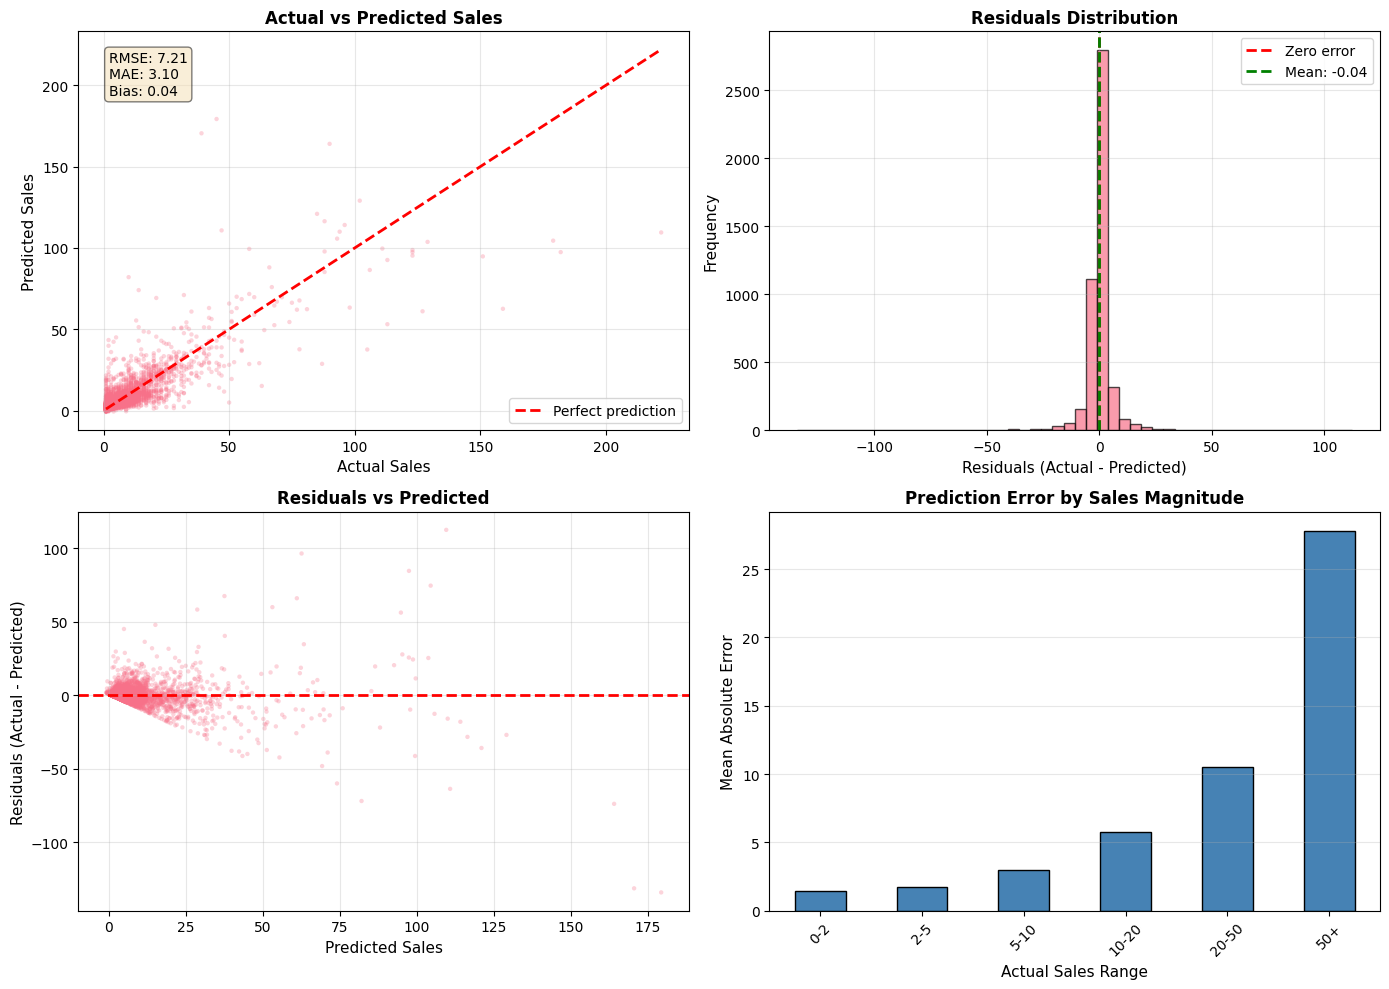


2. Key Visual Insights:
   Panel 1 (Actual vs Predicted):
     - Points clustered near diagonal = good predictions
     - Scatter pattern shows prediction uncertainty

   Panel 2 (Residuals Distribution):
     - Centered near zero = unbiased model
     - Spread indicates prediction variability

   Panel 3 (Residuals vs Predicted):
     - Random scatter = good (no systematic bias)
     - Fan shape = heteroscedasticity (expected in retail)

   Panel 4 (Error by Magnitude):
     - Shows how error varies with sales volume
     - Higher errors at higher volumes expected (larger absolute scale)


In [14]:
# Cell 8: Prediction Visualizations

print("=== PREDICTION VISUALIZATIONS ===\n")

# Calculate residuals
residuals = y_test - y_test_pred

print("1. Create 4-panel visualization:")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Actual vs Predicted
ax1 = axes[0, 0]
ax1.scatter(y_test, y_test_pred, alpha=0.3, s=10, edgecolors='none')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect prediction')
ax1.set_xlabel('Actual Sales', fontsize=11)
ax1.set_ylabel('Predicted Sales', fontsize=11)
ax1.set_title('Actual vs Predicted Sales', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add metrics text
textstr = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nBias: {bias:.2f}'
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Panel 2: Residuals Distribution
ax2 = axes[0, 1]
ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero error')
ax2.axvline(x=residuals.mean(), color='g', linestyle='--', linewidth=2, 
            label=f'Mean: {residuals.mean():.2f}')
ax2.set_xlabel('Residuals (Actual - Predicted)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Residuals Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Panel 3: Residuals vs Predicted
ax3 = axes[1, 0]
ax3.scatter(y_test_pred, residuals, alpha=0.3, s=10, edgecolors='none')
ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Predicted Sales', fontsize=11)
ax3.set_ylabel('Residuals (Actual - Predicted)', fontsize=11)
ax3.set_title('Residuals vs Predicted', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Panel 4: Error by Sales Magnitude
ax4 = axes[1, 1]
# Bin actual sales and calculate mean absolute error per bin
bins = [0, 2, 5, 10, 20, 50, 250]
bin_labels = ['0-2', '2-5', '5-10', '10-20', '20-50', '50+']
y_test_binned = pd.cut(y_test, bins=bins, labels=bin_labels)
error_by_bin = pd.DataFrame({
    'actual': y_test, 
    'error': np.abs(residuals),
    'bin': y_test_binned
}).groupby('bin')['error'].mean()

error_by_bin.plot(kind='bar', ax=ax4, color='steelblue', edgecolor='black')
ax4.set_xlabel('Actual Sales Range', fontsize=11)
ax4.set_ylabel('Mean Absolute Error', fontsize=11)
ax4.set_title('Prediction Error by Sales Magnitude', fontsize=12, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUTS_FIGURES / 'w03_d01_baseline_evaluation.png', dpi=150, bbox_inches='tight')
print(f"   Saved to:  {OUTPUTS_FIGURES / 'w03_d01_baseline_evaluation.png'}")
plt.show()

print(f"\n2. Key Visual Insights:")
print(f"   Panel 1 (Actual vs Predicted):")
print(f"     - Points clustered near diagonal = good predictions")
print(f"     - Scatter pattern shows prediction uncertainty")

print(f"\n   Panel 2 (Residuals Distribution):")
print(f"     - Centered near zero = unbiased model")
print(f"     - Spread indicates prediction variability")

print(f"\n   Panel 3 (Residuals vs Predicted):")
print(f"     - Random scatter = good (no systematic bias)")
print(f"     - Fan shape = heteroscedasticity (expected in retail)")

print(f"\n   Panel 4 (Error by Magnitude):")
print(f"     - Shows how error varies with sales volume")
print(f"     - Higher errors at higher volumes expected (larger absolute scale)")

## 7. Day 1 Summary & Next Steps

**Day 1 Objectives: COMPLETE ✓**

**Accomplished:**
- ✓ Loaded feature-engineered dataset (300,896 × 57 columns)
- ✓ Created 7-day gap train/test split (prevents lag7 leakage)
- ✓ Separated 45 features from target variable
- ✓ Trained XGBoost baseline (0.28 seconds, 100 estimators)
- ✓ Evaluated with 6 comprehensive metrics
- ✓ Created 4-panel visualization

**Baseline Performance (March 2014 Test Set):**
- **RMSE: 7.21** (primary metric for tuning)
- **MAE: 3.10** units
- **Bias: 0.04** (nearly unbiased)
- **MAPE: 69.11%** (high due to sparse low-volume items)
- **Improvement over naive: 41.75%**

**Key Insights:**
1. Model nearly unbiased (0.04 over-forecast)
2. 41.75% improvement over naive baseline validates feature engineering
3. High MAPE expected in sparse retail (many low-volume items)
4. Heteroscedasticity present (fan shape in residuals) - normal for retail
5. 7-day gap successfully prevents lag7 leakage

**Deliverables:**
- Baseline model trained and saved in memory
- Comprehensive evaluation metrics documented
- Visualization saved: w03_d01_baseline_evaluation.png

**Next Steps (Day 2):**
- Set up MLflow experiment tracking
- Log baseline run (params, metrics, plots)
- Compute permutation importance (top 15 features)
- Generate SHAP analysis (feature impact)
- Run ablation study (validate feature groups)

**Decision Points for Day 2:**
- Which features are most important? (permutation)
- How do features influence predictions? (SHAP)
- Are oil features useful? (ablation validates DEC-012)

In [15]:
# Cell 9: Save Day 1 Progress & Summary

print("=== DAY 1 PROGRESS SUMMARY ===\n")

print("1. Baseline Model Performance:")
metrics_summary = {
    'MAE': mae,
    'RMSE': rmse,
    'Bias': bias,
    'MAD': mad,
    'rMAD_%': rmad,
    'MAPE_%': mape,
    'Improvement_over_naive_%': (1 - rmse/np.std(y_test)) * 100
}

for metric, value in metrics_summary.items():
    print(f"   {metric}: {value:.4f}")

print(f"\n2. Dataset Summary:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Gap period: 7 days")
print(f"   Training period: 52 days")
print(f"   Test period: 31 days")

print(f"\n3. Model Configuration:")
print(f"   Algorithm: XGBoost Regressor")
print(f"   n_estimators: {model.n_estimators}")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Categorical features: Enabled")
print(f"   Random state: {model.random_state}")

print(f"\n4. Feature Categories Used:")
print(f"   - Base features: 3")
print(f"   - Lag features: 7")
print(f"   - Rolling features: 12")
print(f"   - Oil features: 6")
print(f"   - Aggregation features: 12")
print(f"   - Promotion features: 3")
print(f"   - Categorical features: 2")
print(f"   Total: 45 features")

print(f"\n5. Files Generated:")
print(f"   - w03_d01_baseline_evaluation.png (4-panel visualization)")

print(f"\n6. Ready for Day 2:")
print(f"   - Baseline RMSE established: {rmse:.4f}")
print(f"   - Model object in memory: 'model'")
print(f"   - Test predictions available: 'y_test_pred'")
print(f"   - Feature matrices prepared: X_train, X_test, y_train, y_test")

print(f"\n=== DAY 1 COMPLETE ===")
print(f"Status: Baseline established, ready for MLflow tracking and feature validation")

=== DAY 1 PROGRESS SUMMARY ===

1. Baseline Model Performance:
   MAE: 3.0957
   RMSE: 7.2127
   Bias: 0.0363
   MAD: 1.2933
   rMAD_%: 43.1110
   MAPE_%: 69.1119
   Improvement_over_naive_%: 41.7476

2. Dataset Summary:
   Training samples: 7,050
   Test samples: 4,686
   Features: 45
   Gap period: 7 days
   Training period: 52 days
   Test period: 31 days

3. Model Configuration:
   Algorithm: XGBoost Regressor
   n_estimators: 100
   Training time: 0.31 seconds
   Categorical features: Enabled
   Random state: 42

4. Feature Categories Used:
   - Base features: 3
   - Lag features: 7
   - Rolling features: 12
   - Oil features: 6
   - Aggregation features: 12
   - Promotion features: 3
   - Categorical features: 2
   Total: 45 features

5. Files Generated:
   - w03_d01_baseline_evaluation.png (4-panel visualization)

6. Ready for Day 2:
   - Baseline RMSE established: 7.2127
   - Model object in memory: 'model'
   - Test predictions available: 'y_test_pred'
   - Feature matrices pr